# Accompanied Notebook for the imsRacing publication

In [2]:
%load_ext autoreload
%autoreload 2

import datetime
import logging
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from typing import Iterable

# this is needed for jupyter notebooks and due to the bad Python implementation of async which does not allow nested loops (and notebooks already start a loop)
# this is likely ONLY useful in notebooks and similar environments
import nest_asyncio
nest_asyncio.apply()

# if the following line doesn't work, please install the IMS Lib
# https://github.com/Mereep/lib_ims
import lib_ims
from lib_ims import ImsFile, ImsDatabase
from plotly import express as px

## Config and other preambles

In [3]:
# Some global definitions

# Adopt this to your needs
IMS_DATASET_PATH = Path('..') / 'paper_data'
assert IMS_DATASET_PATH.exists(), "Please make sure the directory you specified exists (Code: 9342583)"

In [4]:
# Make logger print out to jupyter notebook and set it to DEBUG level
logger = lib_ims.get_ims_logger()
if not logger.hasHandlers():
    consoleHandler = logging.StreamHandler()
    logger.addHandler(consoleHandler)
    logger.setLevel(logging.DEBUG)

    logger.info("Configured logging")
else:
    logger.info("Logging was already configured")

Configured logging


## Download the dataset

In [5]:
# View available datasets

print(lib_ims.get_ims_versions())

[('ims_racing_1_paper', 'Dataset as described in the IMSRacing Publication', 'Attribution-ShareAlike 4.0 International. Please take note of the included licence.txt file')]


In [4]:
# Downloads paper dataset `ims_racing_1_paper` (uncomment the following line; the download will take some time!); you may want to download a more recent version

# lib_ims.download_db('ims_racing_1_paper', IMS_DATASET_PATH)

## Instantiate the dataset and extract some info

In [6]:
db = ImsDatabase(IMS_DATASET_PATH)

In [7]:
print("Included players, tracks and simulators", db.players, db.tracks, db.simulators)

Included players, tracks and simulators {'DAKL171', 'PASZ200', 'MAAK191', 'FAMB312', 'CHIP260', 'TOINFR270', 'INBW112'} {'tmm_lausitzring', 'ks_nurburgring'} {'h-pod', 'd-pod', '2-pod'}


In [8]:
print("Recording files:", db.n_recordings)

Recording files: 111


In [9]:
print("Recording days", sorted(set(datetime.date(year=file.start_time.year,
                                                 month=file.start_time.month,
                                                 day=file.start_time.day).__str__() for file in db)))

print("Recording session numbers", sorted(set(file.global_session_number for file in db)))

Recording days ['2022-01-31', '2022-02-07', '2022-02-14', '2022-02-21', '2022-02-28', '2022-03-07', '2022-03-21', '2022-03-28', '2022-04-04', '2022-04-11']
Recording session numbers [1, 2, 3, 4, 5, 6, 7, 8]


### Look into the telemetry data and static data

In [10]:
db.recordings[0].telemetry.head()

,log_time_ms,packetId_graphic,AC_STATUS,AC_SESSION_TYPE,currentTime,lastTime,bestTime,split,completedLaps,position,...,tyreContactHeading_RL_z,tyreContactHeading_RR_x,tyreContactHeading_RR_y,tyreContactHeading_RR_z,brakeBias,localVelocity_x,localVelocity_y,localVelocity_z,currentMaxRpm,swerve_deg
0,0,17,2,0,0:00:900,-:--:---,-:--:---,,0,1,...,-0.339977,0.939057,-0.000732,-0.343761,0.62,-0.000236,-0.002599,-0.000252,8500,141.508061
1,31,21,2,0,0:00:933,-:--:---,-:--:---,,0,1,...,-0.340051,0.939058,-0.000732,-0.343758,0.62,-0.000772,-0.002746,-0.000015,8500,93.324742
2,62,25,2,0,0:00:969,-:--:---,-:--:---,,0,1,...,-0.340074,0.939070,-0.000731,-0.343725,0.62,-0.000468,-0.002723,0.000293,8500,59.814710
3,94,29,2,0,0:01:002,-:--:---,-:--:---,,0,1,...,-0.340056,0.939057,-0.000732,-0.343762,0.62,0.000045,-0.002622,0.000178,8500,-21.224561
4,126,33,2,0,0:01:035,-:--:---,-:--:---,,0,1,...,-0.340037,0.939073,-0.000731,-0.343717,0.62,0.000080,-0.002790,0.000118,8500,-47.041929


In [10]:
db.recordings[0].static_data

{'startTime': '2022-03-28T12:15:32.661692',
 'endTime': '2022-03-28T13:06:25.756430',
 'numCars': 1,
 'playerId': 'PASZ200',
 'simulator': 'd-pod',
 'track': {'name': 'ks_nurburgring',
  'variation': 'layout_gp_b',
  'trackLength': 5067.3388671875},
 'carDetails': {'carModel': 'lotus_exige_v6_cup',
  'hasDRS': 0,
  'hasERS': 0,
  'hasKERS': 0,
  'maxFuel': 40.0,
  'maxRpm': 7200},
 'extra_info': {'session_number_global': 8,
  'session_number_imsracing1': 8.0,
  'data_sets': 'imsracing1'}}

### Count completed laps
this code iterates over the whole db and
- counts the total laps
- counts the laps grouped by players

In [16]:
lap_count_total = 0

# mapping of player_id => [with_ai_count, without_ai_count]
laps_by_name = {
    player: [0, 0] for player in db.players
}

for recording in db:
    lap_count = len(recording.telemetry['completedLaps'].unique())
    # mostly, when driving with AI the players did drive over the finish line, which
    # leaves an unfinished last round
    if recording.is_with_ai_players:
        lap_count -= 1

    lap_count_total += lap_count
    laps_by_name[recording.player_id][0 if recording.is_with_ai_players else 1] += lap_count

/var/folders/jr/798md38j1mx89bn20l53rdb00000gn/T/ipykernel_52698/2351098567.py:9: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  lap_count = len(recording.telemetry['completedLaps'].unique())


In [17]:
print("Finished laps total: ", lap_count_total)

Finished laps total:  2209


In [19]:
print("laps grouped by player (with ai, without ai): ", laps_by_name)

laps grouped by player (with ai, without ai):  {'DAKL171': [160, 168], 'PASZ200': [180, 148], 'MAAK191': [165, 182], 'FAMB312': [160, 166], 'CHIP260': [178, 147], 'TOINFR270': [119, 107], 'INBW112': [156, 173]}


## Plot some useful data
Firstly, we define some helper functions which extract lap times from the database and generate boxplots from the data

In [20]:
def build_laptimes_for_recordings(recordings: Iterable[ImsFile]) -> tuple[dict[int, list[float]], dict[int, list[float]]]:
    """ fetches all lap times and groups them by the users' session
    :return lap times WITH, lap times WITHOUT AI-controlled cars (i.e., was the player driving alone or with other cars)
    """
    with_ai_times: dict[int, list[float]] = {}
    without_ai_times: dict[int, list[float]] = {}

    # iterate over all recordings
    for file in recordings:
       print("Processing file from time", file.start_time, "of user", file.player_id)

       # extract the session number
       session_nr = file.global_session_number

       # create a lookup for the session if not already there
       if not session_nr  in with_ai_times:
           with_ai_times[session_nr] = []

       if not session_nr in without_ai_times:
           without_ai_times[session_nr] = []

       # actually load the telemetry data
       df: pd.DataFrame = file.telemetry

       # group the data by laps and extract the minimum and maximum log time for each lap respectively
       times = df.groupby('completedLaps').agg({
           'log_time_ms': ['min', 'max']
       })

       # build the element-wise difference
       diffs = list((times['log_time_ms']['max'] - times['log_time_ms']['min']) / 1000)

       # and filter out the last and first round (likely not complete or driving out the starting lane, we are not interested in this)
       # + filter outliers (likely end-recordings)
       diffs = [diff for diff in diffs[1:-1] if 60 <= diff <= 240]
       diff_avg = sum(diffs) / len(diffs)
       print("Avg round time in s", diff_avg)

       if file.is_with_ai_players:
           with_ai_times[session_nr] += list(diffs)
       else:
           without_ai_times[session_nr] += list(diffs)

    return with_ai_times, without_ai_times

In [31]:
def crate_laptime_plot(with_ai_times: dict[int, Iterable[float]],
                       without_ai_times=dict[int, Iterable[float]],
                       from_session_number: int = 1,
                       to_session_number: int=8) -> plt.Figure:
    """ creates a boxplot having lap time candles build for each day grouped by AI times and NON-AI times"""

    # define some optical settings
    bar_width       =   0.3         # width of each bar (2 will be grouped)
    show_fliers     =   False       # outliers
    wobble          =   0.025       # random data points movement
    dp_size         =   12          # size of data points drawn
    font_size_base  =   16          # will be used as smallest font
    color_bar_1     =   '#2a6bb7'   # color of bar group 1
    color_bar_2     =   '#E97817'   # color of bar group 2
    color_dps       =   '#27a845'   # color of data points

    # available read session numbers
    sessions_sorted = [included for included in sorted({*with_ai_times, *without_ai_times}, reverse=True) if from_session_number <= included <= to_session_number]

    # create a plot using matplotlib
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    # define labels as the sorted session numbers
    y_labels = sessions_sorted

    # define the y-placements of the bars
    y_locations_2 = np.array(range(len(sessions_sorted))) - 0.15
    y_locations_1 = [loc + (bar_width + 0.1) for loc in y_locations_2]

    # draw the without ai bars
    patches_without = ax.boxplot(x=[without_ai_times[t] for t in sessions_sorted if t in without_ai_times],
                                 positions=y_locations_1,
                                 vert=False, widths=bar_width,
                                 labels=[''] * len(y_labels),
                                 showfliers=show_fliers,
                                 patch_artist=True,
                                 medianprops={'color': 'white'})

    # ... and the with ai bars
    patches_with = ax.boxplot(x=[with_ai_times[t] for t in sessions_sorted if t in with_ai_times],
                              positions=y_locations_2,
                              vert=False, widths=bar_width,
                              labels=[''] * len(y_labels),
                              showfliers=show_fliers,
                              patch_artist=True,
                              medianprops={'color': 'white'}
                              )

    # draw the datapoints on top (single lap times)
    for i, sess_number in enumerate(sessions_sorted):
        ax.scatter(without_ai_times[sess_number],
                   [y_locations_1[i] + np.random.normal(0, wobble) for _ in range(len(without_ai_times[sess_number]))], color=color_dps, s=dp_size, zorder=2)

        ax.scatter(with_ai_times[sess_number],
                   [y_locations_2[i] + np.random.normal(0, wobble) for _ in range(len(with_ai_times[sess_number]))], color=color_dps, s=dp_size, zorder=2)

    # color the bars
    for p in patches_without['boxes']:
        p.set_facecolor(color_bar_1)

    for p in patches_with['boxes']:
        p.set_facecolor(color_bar_2)

    # set label for x axis
    ax.set_xlabel('Lap Time in Seconds', fontsize=font_size_base*1.2)
    ax.set_ylabel("Session Number", fontsize=font_size_base*1.2)

    # define the ticks and the tick-positioning of the y-axis (session numbers)
    ax.set_yticks(ticks=list(tick -0.15 for tick in y_locations_1),
                  labels=y_labels,
                  rotation=45, fontsize=font_size_base)

    plt.xticks(fontsize=font_size_base)

    # draw the legend to inform the reader which bar represents which data
    legend = ax.legend([patches_without['boxes'][0],  patches_with['boxes'][0]],
                       ['Without AI Players', 'With AI Players'],
                       title="Lap Times",
                       fontsize=font_size_base,
                       title_fontsize=font_size_base*1.2)

    # just align the title left (seems a bit hacky though)
    legend._legend_box.align = "left"

    # remove spaces and stuffs
    _ = fig.tight_layout()

    # ... and done
    return fig

### Extract lap times and draw box plots
lap times are extracted separately for both tracks for each session and grouped by with AI and without AI recordings

In [22]:
nurburg_ring_files = [file for file in db if file.track_id.startswith('ks_nurburgring')]
lausitzring_files = [file for file in db if file.track_id.startswith('tmm_lausitzring')]

In [23]:
# and extract lap times grouped by sessions and with/without AI
nurburg_ring_laptimes = build_laptimes_for_recordings(nurburg_ring_files)
lausitzring_laptimes = build_laptimes_for_recordings(lausitzring_files)

Processing file from time 2022-01-31 12:10:36.681889 of user TOINFR270


/var/folders/jr/798md38j1mx89bn20l53rdb00000gn/T/ipykernel_52698/366484150.py:23: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  df: pd.DataFrame = file.telemetry


Avg round time in s 132.39825
Processing file from time 2022-01-31 13:05:13.473306 of user TOINFR270
Avg round time in s 131.2297894736842
Processing file from time 2022-01-31 13:05:49.989659 of user PASZ200
Avg round time in s 160.59284210526317
Processing file from time 2022-01-31 14:15:50.377991 of user PASZ200
Avg round time in s 151.11416666666668
Processing file from time 2022-01-31 15:01:22.597088 of user INBW112
Avg round time in s 165.03984210526318
Processing file from time 2022-01-31 16:02:08.904579 of user DAKL171
Avg round time in s 139.9647368421053
Processing file from time 2022-01-31 16:03:56.366080 of user INBW112
Avg round time in s 152.16723529411763
Processing file from time 2022-01-31 16:57:44.828904 of user DAKL171
Avg round time in s 138.03468421052634
Processing file from time 2022-01-31 17:56:51.895124 of user MAAK191
Avg round time in s 138.62644999999998
Processing file from time 2022-01-31 18:57:33.523319 of user MAAK191
Avg round time in s 135.6969473684210

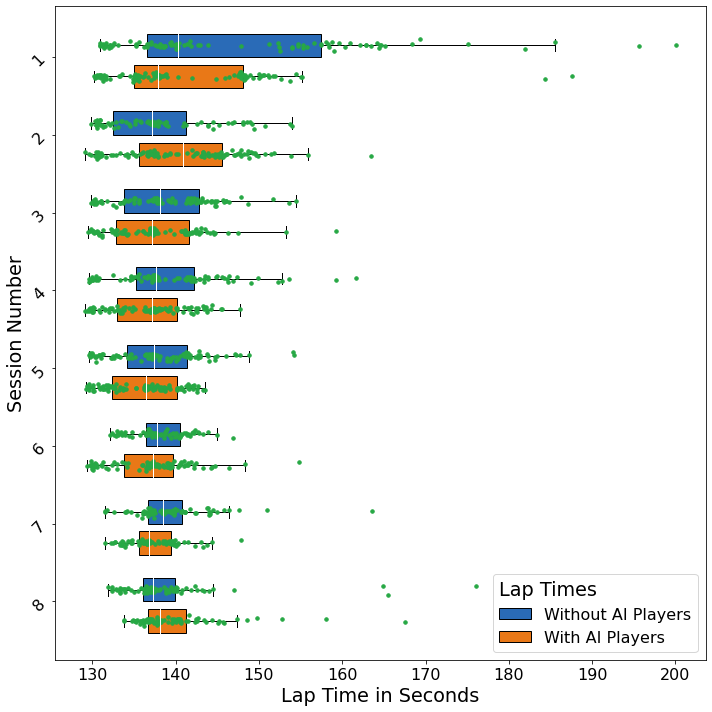

In [32]:
fig_nurburg_ring = crate_laptime_plot(with_ai_times=nurburg_ring_laptimes[0], without_ai_times=nurburg_ring_laptimes[1])
fig_nurburg_ring.savefig('lap_times_nurburgring.png', dpi=300)

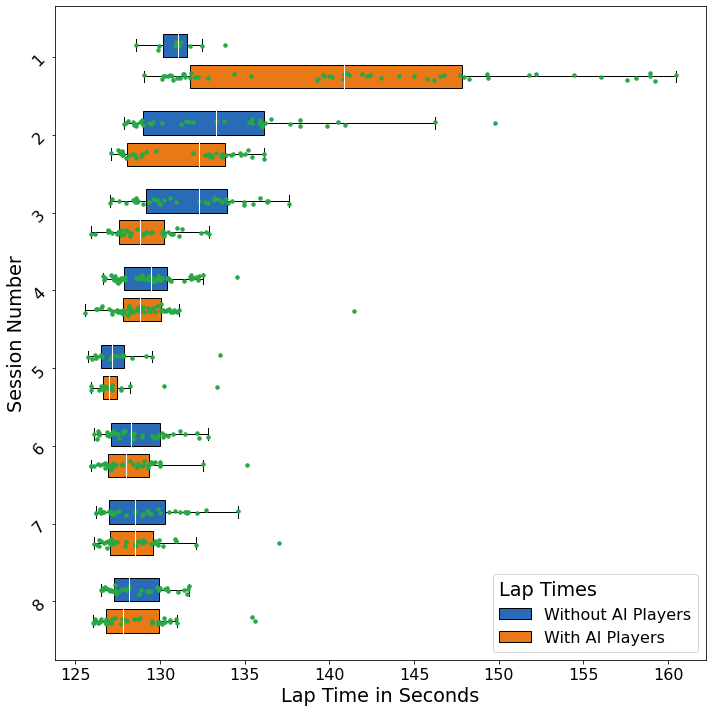

In [33]:
fig_lausitzring = crate_laptime_plot(with_ai_times=lausitzring_laptimes[0], without_ai_times=lausitzring_laptimes[1])
fig_lausitzring.savefig('lap_times_lausitzring.png', dpi=300)

## Plot a specific track and highlight the speed

In [59]:
# choose a specific recording (recording with AI cars of player MAAK191 of the 04.04.)
file, = [file for file in db if
         file.start_time.month == 4 and file.start_time.day == 4 and file.player_id == 'MAAK191' and file.is_with_ai_players is True
         ]

print(file)

Recording of player MAAK191 at 2022-04-04 16:24:17.211360 on simulator 2-pod


In [64]:
# load the telemetry data and extract the lap infos
relevant_telemetry = file.telemetry[['carCoordinates_00_x','carCoordinates_00_z','speedKmh', 'completedLaps', 'gear']]
df_selected_round = relevant_telemetry[relevant_telemetry['completedLaps'] == 3].copy()

# just invert the car positions to match common view of the track
df_selected_round['carCoordinates_00_x'] = df_selected_round['carCoordinates_00_x'].apply(lambda x: x*-1)
df_selected_round['carCoordinates_00_z'] = df_selected_round['carCoordinates_00_z'].apply(lambda x: x*-1)
df_selected_round['Km/h'] = df_selected_round['speedKmh']
df_selected_round['Gear'] = df_selected_round['gear']

In [67]:
fig = px.scatter(df_selected_round,
                 x='carCoordinates_00_x',
                 y='carCoordinates_00_z',
                 color='Km/h',
                 opacity=1.0)
fig.update_layout(
    font=dict(
        size=20,
    )
)
fig.show()

2